In [10]:
from server import img_processing, pre_load_nets, test
import matplotlib.pyplot as plt
import cv2
import numpy as np
import io

In [11]:
img = cv2.imread(r"C:\Users\admin\Desktop\pjt_main\test0.png")

In [3]:

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches ='tight')
    buf.seek(0)
    img = plt.imread(buf)
    return img

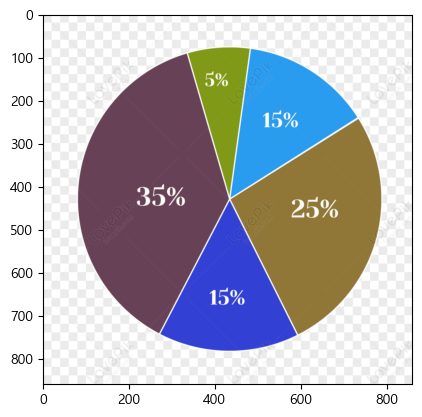

In [4]:
%matplotlib inline
plt.imshow(img)
fig = plt.gcf()
plot_img = fig2img(fig)
plot_img = np.array(plot_img*255., dtype='uint8')


In [5]:
methods = pre_load_nets("KPGrouping", "./img/", "./cache/", "best")

Preloading KPGrouping model
Loading KPGrouping model
Configuration file loading complete
Config loading complete
Loading parameters at iteration: best
Label file: None
Building neural network...
Import complete
Keypoint grouping enabled.
Initiating losses
Total parameters: 199641774
Loading parameters...
Loading model from ./cache/nnet\KPGrouping\KPGrouping_best.pkl


In [6]:
result = test(img, methods, 'KPGrouping')

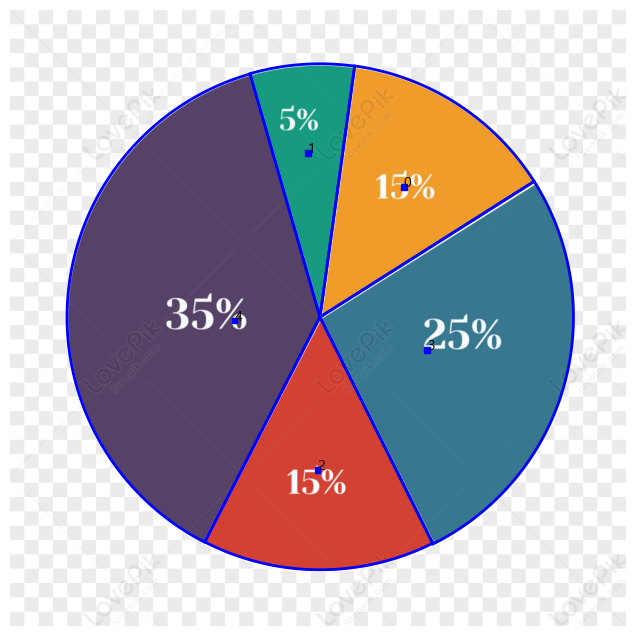

In [7]:
%matplotlib inline

from matplotlib.patches import Polygon
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
from pie import pie_relocation

patches = []

fig, ax = plt.subplots(1, figsize=(8,8))
ax.set_axis_off()

patch_size = 4
line_colors= ['green', 'orange','red','blue',]

if result[-1] == 2:
    result = pie_relocation(result)

for n, p in enumerate(result):
    
    poly_point = []
    
    if p[-2] > 0. and p[-1] == 0:
        #좌상, 우하 확인
        if p[4] > p[2]:
            tl = (p[2],p[3])
            br = (p[4],p[5])
        else:
            tl = (p[4],p[5])
            br = (p[2],p[3])
        
        poly_point.append(tl)
        poly_point.append((br[0],tl[1]))
        poly_point.append(br)
        poly_point.append((tl[0],br[1]))
        
        patches.append(Rectangle((p[0]-patch_size, p[1]-patch_size), patch_size*2,patch_size*2, color='blue'))
        patches.append(Polygon(poly_point, fill=None ,edgecolor='red',ls='solid',lw=1))
        plt.text(p[0], p[1], f"{n}")
        
    elif p[-2] > 0. and p[-1] == 1:

        # (xlist, ylist) 형태로 변환
        line_points = np.array((p[2:-2:2],p[3:-2:2]))
        # 각요소 (x,y)로 묶음
        line_points = line_points.T
        # x 값 기준으로 정렬
        line_points = sorted(line_points,key=lambda x:x[0])
        line_points = np.array(line_points)
        # (xlist, ylist) 형태로 변환
        
        for i in line_points.T:
            poly_point.append(i)

        color = line_colors.pop()
        for i in line_points:
            patches.append(Circle(i,color=color,radius=4))
        
        patches.append(Line2D(poly_point[0],poly_point[1],color=color,ls='solid',lw=3))
        
        plt.text(p[0], p[1], f"{n}")
    elif p[-2] > 0. and p[-1] == 2:
        
        # 벡터의 내각 계산
        theta = np.arccos(np.dot((p[2]- p[6],p[3]-p[7]), (p[4]- p[6],p[5]-p[7]))/ (np.linalg.norm((p[2]- p[6],p[3]-p[7]))*np.linalg.norm((p[4]- p[6],p[5]-p[7]))))
        # 벡터 시계 방향 확인 
        is_clock = np.cross((p[2]- p[6],p[3]-p[7]), (p[4]- p[6],p[5]-p[7]))
        is_clock = is_clock/abs(is_clock)
        
        theta = theta * is_clock
        
        # 절반 회전 했을때 벡터
        check_p = ((p[2] - p[6]) * np.cos(theta *0.5) - (p[3] - p[7]) * np.sin(theta *0.5) + p[6],
                (p[2]- p[6]) * np.sin(theta *0.5) + (p[3] - p[7]) * np.cos(theta *0.5) + p[7])
        
        # 절반 회전 했을때 벡터 와 부채꼴 중심점 벡터 방향 확인
        chkeck_clock = np.dot((check_p[0]- p[6],check_p[1]-p[7]), (p[0]- p[6],p[1]-p[7])) / (np.linalg.norm((check_p[0]- p[6],check_p[1]-p[7])) * np.linalg.norm((p[0]- p[6],p[1]-p[7])))
        
        # 180도가 넘는 부채꼴
        if chkeck_clock < 0:
            theta = (2*np.pi - abs(theta)) * -theta / abs(theta)
            
        poly_point.append((p[6],p[7]))
        poly_point.append((p[2],p[3]))
        
        for i in range(1,101):
            poly_point.append(((p[2] - p[6]) * np.cos(theta * i / 100) - (p[3] - p[7]) * np.sin(theta * i / 100) + p[6],
            (p[2]- p[6]) * np.sin(theta * i / 100) + (p[3] - p[7]) * np.cos(theta * i / 100) + p[7]))

        patches.append(Rectangle((p[0]-patch_size, p[1]-patch_size), patch_size*2,patch_size*2, color='blue'))
        patches.append(Polygon(poly_point, fill=None ,edgecolor='blue',ls='solid',lw=2))
        plt.text(p[0], p[1], f"{n}")
        

for patch in patches:
    ax.add_artist(patch)

ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

2024-06-16 17:00:57 | WARNING | easyocr.easyocr | Using CPU. Note: This module is much faster with a GPU.


([[[371, 435, 129, 173], [504, 600, 220, 270], [211, 341, 393, 455], [571, 695, 421, 483], [380, 476, 632, 682], [763, 829, 787, 857]]], [[[[517.3866303610594, 87.2674490591073], [551.6122049415065, 116.06930955936934], [490.6133696389407, 184.7325509408927], [456.38779505849345, 155.93069044063066]], [[502.28501414857493, 162.97100848914494], [520.7179581586178, 146.13330878759388], [531.7149858514251, 159.02899151085506], [513.2820418413822, 175.86669121240612]], [[503.29319886256286, 157.12905581266637], [518.754192535683, 169.03937075426884], [487.70680113743714, 205.87094418733363], [473.245807464317, 193.96062924573116]], [[105.05576303174938, 503.0899677650968], [187.2021249682742, 424.5110529492872], [212.94423696825064, 460.9100322349032], [130.7978750317258, 539.4889470507128]], [[177.89059960754955, 487.3358994113243], [205.75141021747842, 461.1465214635532], [217.10940039245045, 475.6641005886757], [189.24858978252158, 501.8534785364468]], [[502.719631200671, 485.4635574408

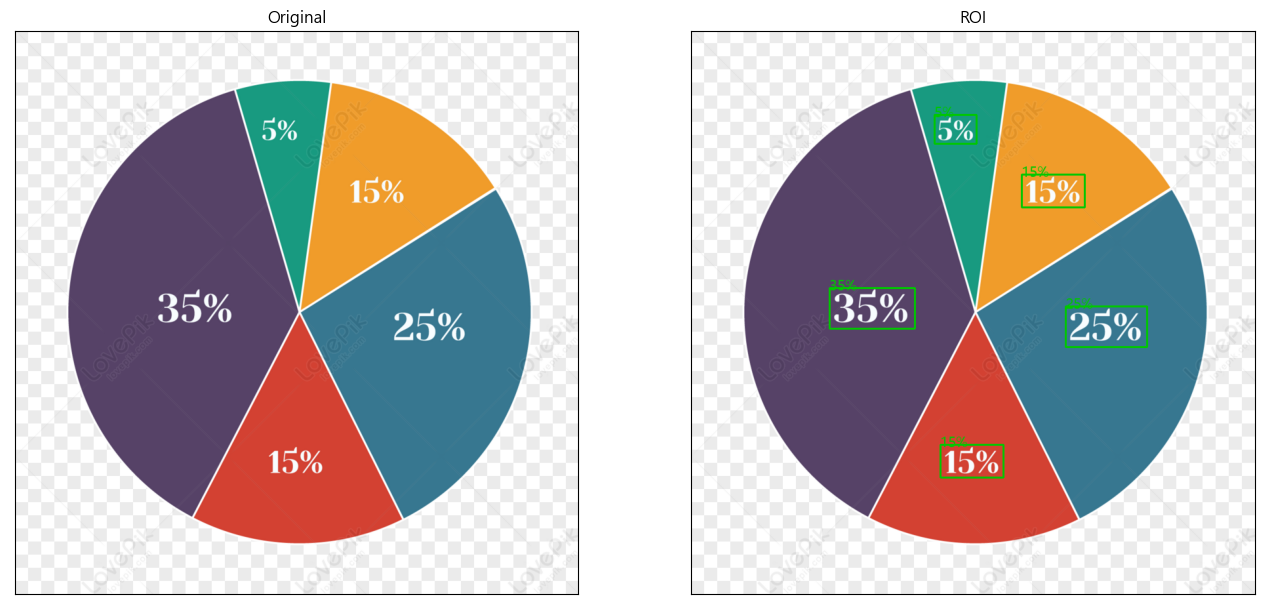

Result : [[[[371, 129], [435, 129], [435, 173], [371, 173]], '5%'], [[[504, 220], [600, 220], [600, 270], [504, 270]], '15%'], [[[211, 393], [341, 393], [341, 455], [211, 455]], '35%'], [[[571, 421], [695, 421], [695, 483], [571, 483]], '25%'], [[[380, 632], [476, 632], [476, 682], [380, 682]], '15%']]


In [8]:
from main import EasyPororoOcr
ocr = EasyPororoOcr()
ocr_img = img
# alpha2 = 0.5 # 명암 조정값
# ocr_img = np.clip((1+alpha2) * img - 128 * alpha2, 0, 255).astype(np.uint8)
# ocr_img = cv2.cvtColor(ocr_img,cv2.COLOR_BGR2GRAY)
# ocr_img = cv2.cvtColor(ocr_img,cv2.COLOR_GRAY2BGR)

text = ocr.run_ocr(ocr_img, debug=True)
print('Result :', text)

2
True
False


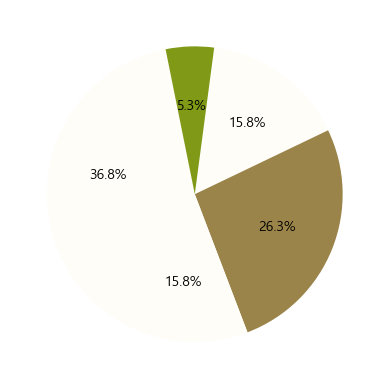

In [12]:
c_img = img_processing(img, methods)

In [9]:
# c_img1 = cv2.imdecode(c_img[1], 1)

c_img2 = cv2.imdecode(c_img[2], 1)

In [10]:
# cv2.imshow('img',c_img1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [11]:
cv2.imshow('img',c_img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

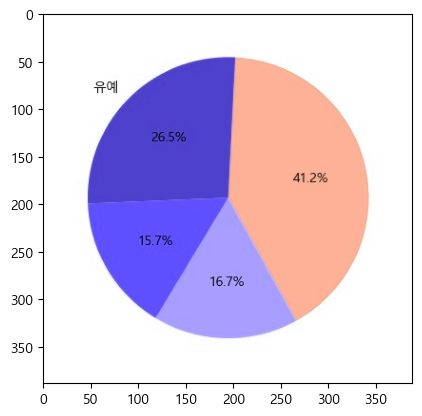

In [92]:
plt.imshow(c_img2)